In [302]:
# required libraries
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset and convert the DATE column to datetime format
df = pd.read_csv('bicup2006.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE')
# Check the structure and first few rows of the dataset
df.head()

/var/folders/m_/pqldzfk929g_v5k72f6g6sx80000gn/T/ipykernel_31496/21430435.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'])


,DATE,TIME,DEMAND
0,2005-03-01,6:30,1
1,2005-03-01,6:45,2
2,2005-03-01,7:00,4
3,2005-03-01,7:15,0
4,2005-03-01,7:30,10


**Part A**

**Part A1**

In [186]:
# statistical summary 
df.describe()

,DEMAND
count,1323.000000
mean,25.872260
std,23.522793
min,0.000000
25%,4.000000
50%,23.000000
75%,40.000000
max,136.000000


In [188]:
df.isnull().sum()

TIME      0
DEMAND    0
dtype: int64

**A2**

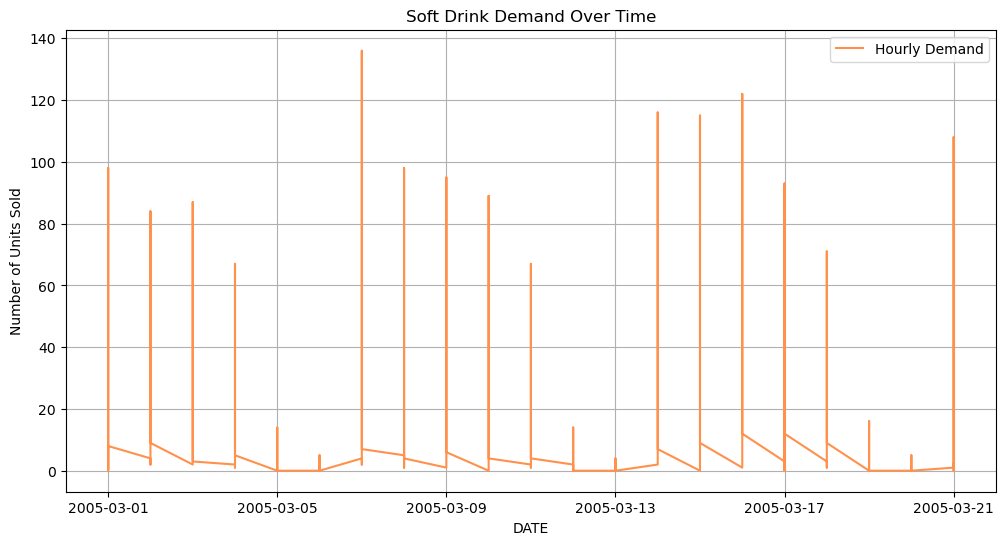

In [202]:
# Plot hourly demand to observe trends 
plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['DEMAND'], label='Hourly Demand', color = '#FF914D')
plt.title('Soft Drink Demand Over Time')
plt.xlabel('DATE')
plt.ylabel('Number of Units Sold')
plt.legend()
plt.grid(True)
plt.show()

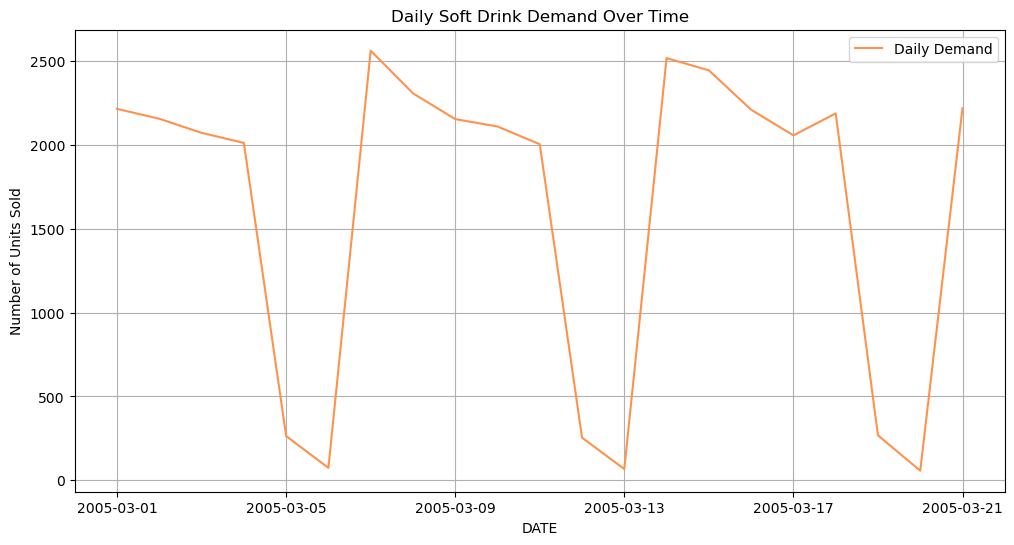

In [204]:
# Aggregate the hourly demand into daily totals for clearer trend analysis
daily_demand = df.resample('D', on='DATE')['DEMAND'].sum().reset_index()
# Plot the daily soft drink demand 
plt.figure(figsize=(12, 6))
plt.plot(daily_demand['DATE'], daily_demand['DEMAND'], label='Daily Demand', color = '#FF914D')
plt.title('Daily Soft Drink Demand Over Time')
plt.xlabel('DATE')
plt.ylabel('Number of Units Sold')
plt.legend()
plt.grid(True)
plt.show()

In [206]:
# Weekly aggregation 
weekly_demand = df.resample('W', on='DATE')['DEMAND'].sum().reset_index()

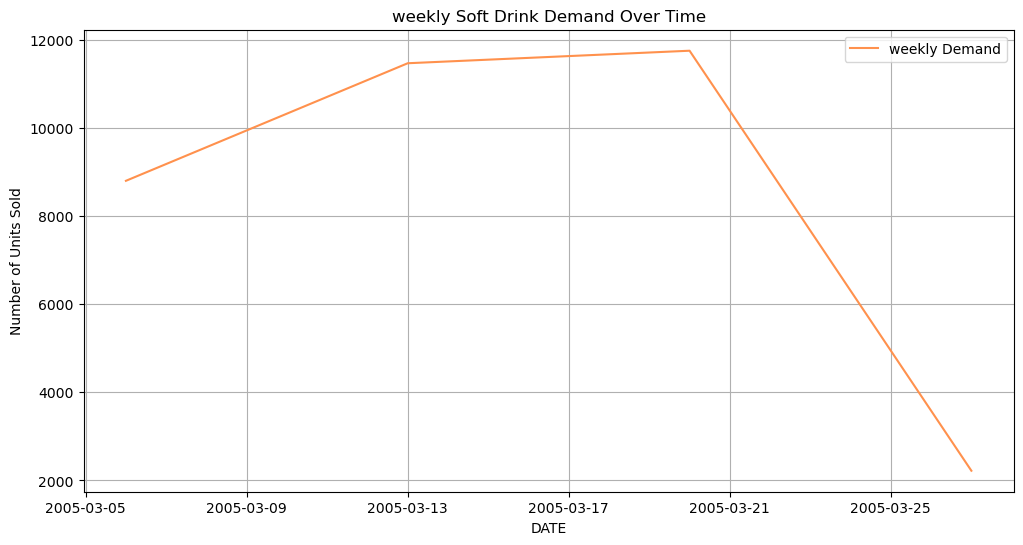

In [208]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_demand['DATE'], weekly_demand['DEMAND'], label='weekly Demand', color = '#FF914D')
plt.title('weekly Soft Drink Demand Over Time')
plt.xlabel('DATE')
plt.ylabel('Number of Units Sold')
plt.legend()
plt.grid(True)
plt.show()

From the weekly demand plot, there’s an increasing trend in soft drink demand during the first three weeks, followed by a drop in the final week, which is likely due to incomplete data.
There also seems to be somewhat regular fluctuations, which may suggest a short-term weekly seasonality.
There’s also some irregular spikes, which could be influenced by external factors like promotions, events, or random variation in buying behavior.

When we are looking at the daily plot, the pattern is obvious, the demand keeps going up and down in a regular way, so we can definitely tell there’s seasonality. The hourly plot is kind of messy and spiky, so it’s hard to see anything clear there, but when I grouped it by day, it made a lot more sense.
In the weekly plot, the seasonality isn’t as sharp, probably because everything gets summed up, but we can still kind of see a wave. So yes, there’s short-term seasonality, especially when looking at daily (or even hourly) trends.

Q1: If we don’t deal with missing time steps, it can mess up the model because it’ll think time moved forward when actually there’s just a gap in the data. It might cause wrong trends or weird seasonality that isn’t real, which can affect the accuracy of the forecast.

Q2: Differencing helps by getting rid of the trend and making the data more steady. Instead of using the actual values, it just looks at the changes between each point. To find out the correct level, I'd check how the plots look after each differencing and also run the ADF test, if the p-value drops below 0.05, it usually means the series is stationary. 

**Part B**

**B1**

In [210]:
# check missing weeks
weeks = pd.date_range(weekly_demand['DATE'].min(),
                          weekly_demand['DATE'].max(),
                          freq='W')

missing = weeks.difference(weekly_demand['DATE'])

print("Missing weeks:", missing)

Missing weeks: DatetimeIndex([], dtype='datetime64[ns]', freq='W-SUN')


all weeks are present, so no need to fill anything

In [212]:
# check for stationarity
adf_test = adfuller(weekly_demand['DEMAND'])

print('ADF Test Results:')
print(f'ADF Statistic: {round(adf_test[0],3)}')
print(f'p-value: {round(adf_test[1],3)}')
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'   {key}: {round(value,3)}')


ADF Test Results:
ADF Statistic: -1.022
p-value: 0.745
Critical Values:
   1%: -10.417
   5%: -5.778
   10%: -3.392


**Null Hypothesis (H0):** The time series has a unit root (non-stationary).

**Alternative Hypothesis (H1):** The time series is stationary.

- The ADF statistic is -1.022, which is not smaller than the critical values.

- The p-value is way above 0.05 (0.745).

- The ADF statistic is significantly greater than all critical values.

Therefore, we fail to reject the null hypothesis. the time series is still non-stationary and needs differencing.

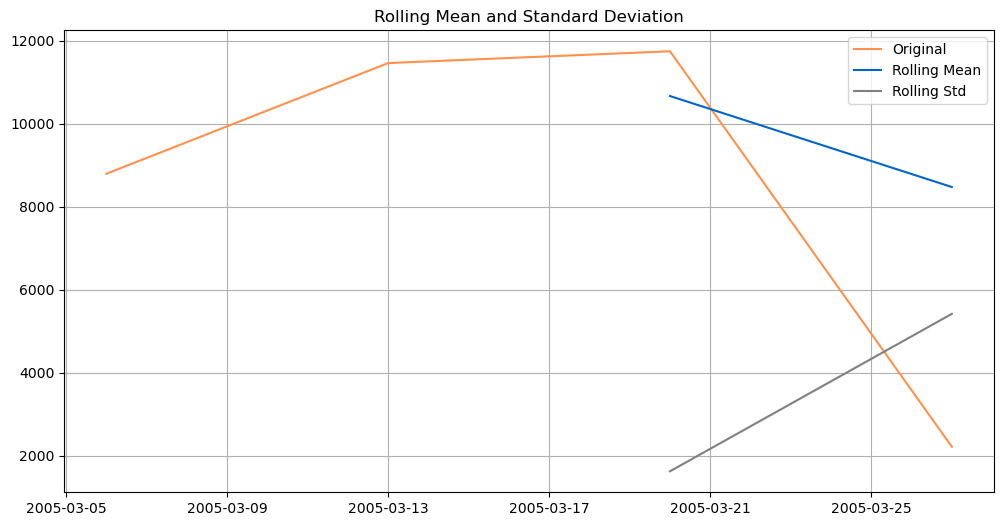

In [214]:
ts = weekly_demand['DEMAND']
# rolling mean and standard deviation
windows = 3
rolling_mean = ts.rolling(window= windows).mean()
rolling_std = ts.rolling(window=windows).std()

plt.figure(figsize=(12, 6))
plt.plot(weekly_demand['DATE'], ts, label='Original', color='#FF914D')
plt.plot(weekly_demand['DATE'], rolling_mean, label='Rolling Mean', color='#0066CC')
plt.plot(weekly_demand['DATE'], rolling_std, label='Rolling Std', color='gray')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

non-stationary

**B2**

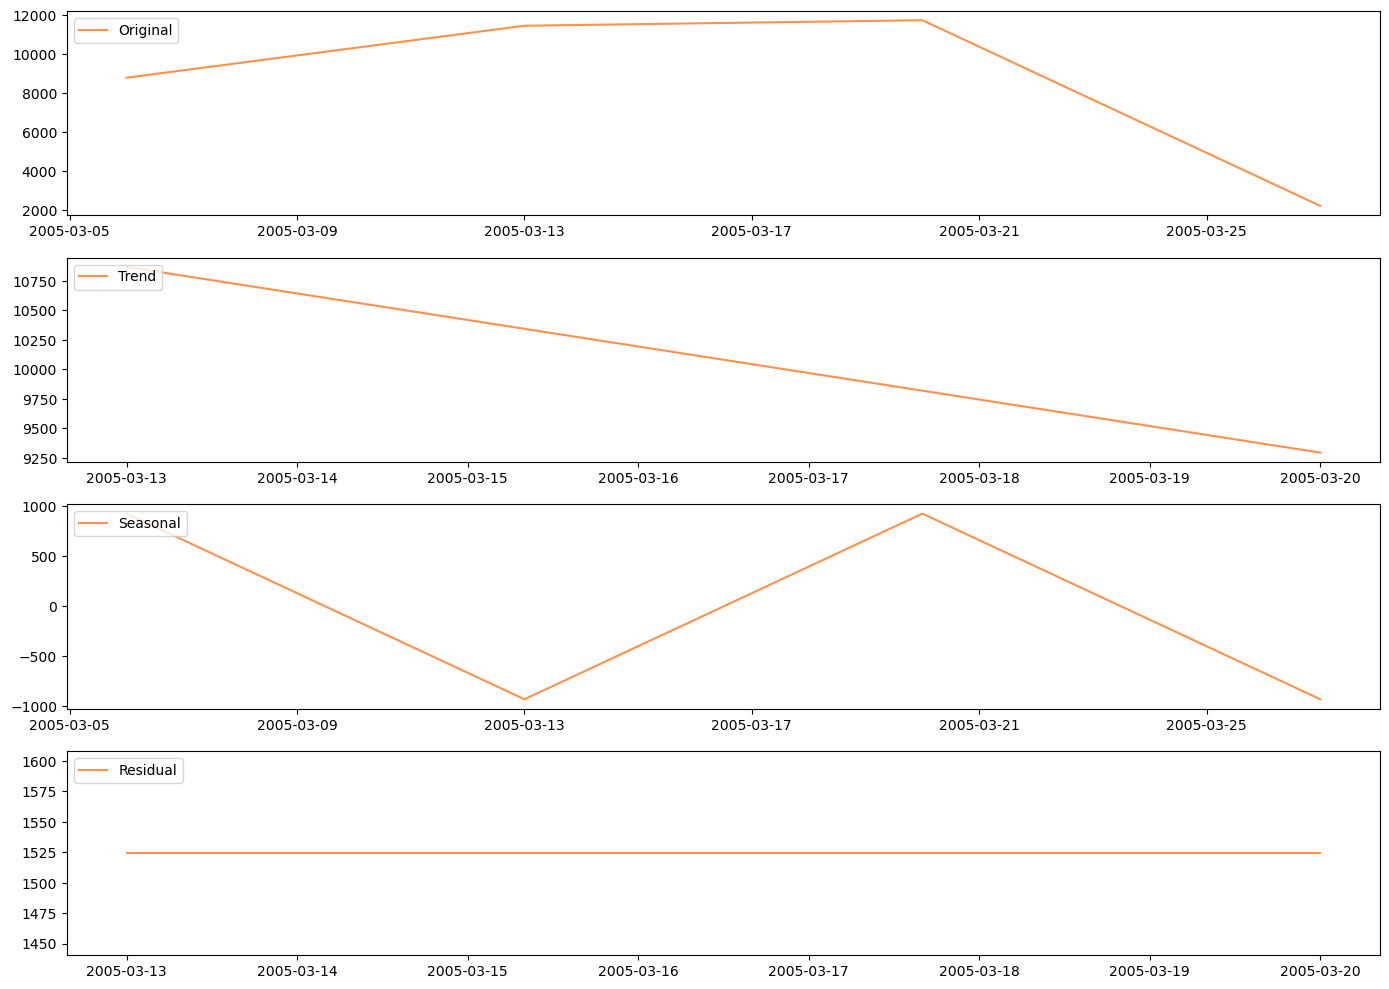

In [218]:
weekly_demand = weekly_demand.set_index('DATE')
#  Decomposing the weekly demand into trend, seasonality, and residual 
decomposition_additive = seasonal_decompose(weekly_demand['DEMAND'], model='additive', period=2)
trend_additive = decomposition_additive.trend
seasonal_additive = decomposition_additive.seasonal
residual_additive = decomposition_additive.resid

# Plotting the additive decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(weekly_demand['DEMAND'], label='Original', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_additive, label='Trend', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_additive, label='Seasonal', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_additive, label='Residual', color = '#FF914D')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


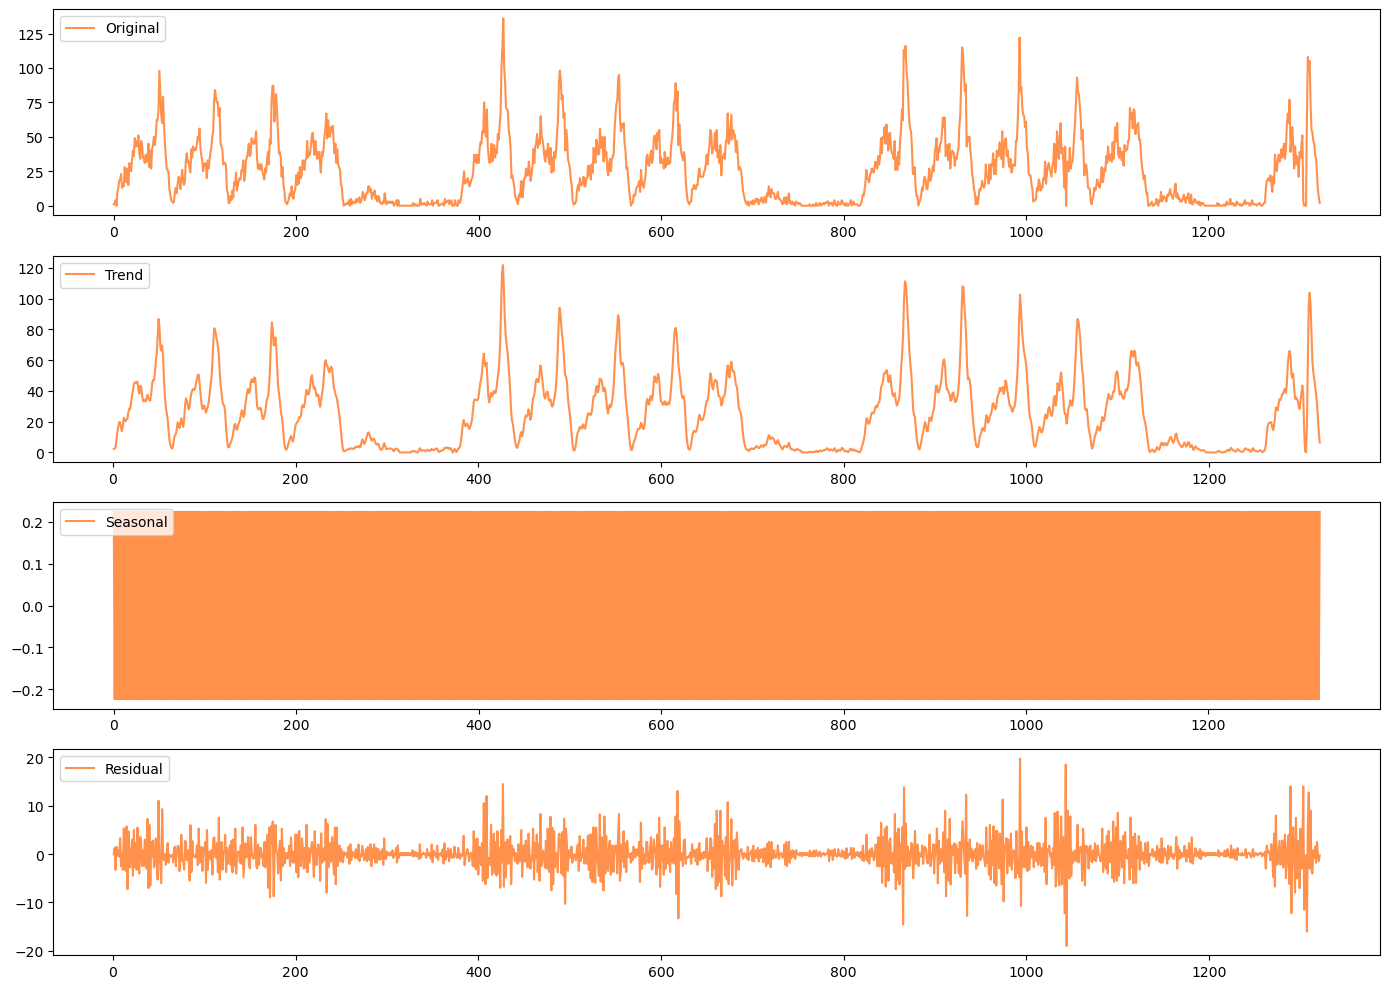

In [320]:
decomposition_additive = seasonal_decompose(df['DEMAND'], model='additive', period=2)
trend_additive = decomposition_additive.trend
seasonal_additive = decomposition_additive.seasonal
residual_additive = decomposition_additive.resid

# Plotting the additive decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df['DEMAND'], label='Original', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_additive, label='Trend', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_additive, label='Seasonal', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_additive, label='Residual', color = '#FF914D')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Since the dataset only includes a few weeks, the decomposition with period=2 works okay for detecting some basic trend and seasonality. It’s not super strong or detailed because there aren’t enough full seasonal cycles, but for now it’s enough to get a general idea. If there were more weeks, like 10 or more, the seasonal and residual components would look much clearer and more reliable.
I’m also planning to check the decomposition using daily data, since it might give more insight into short-term seasonality.


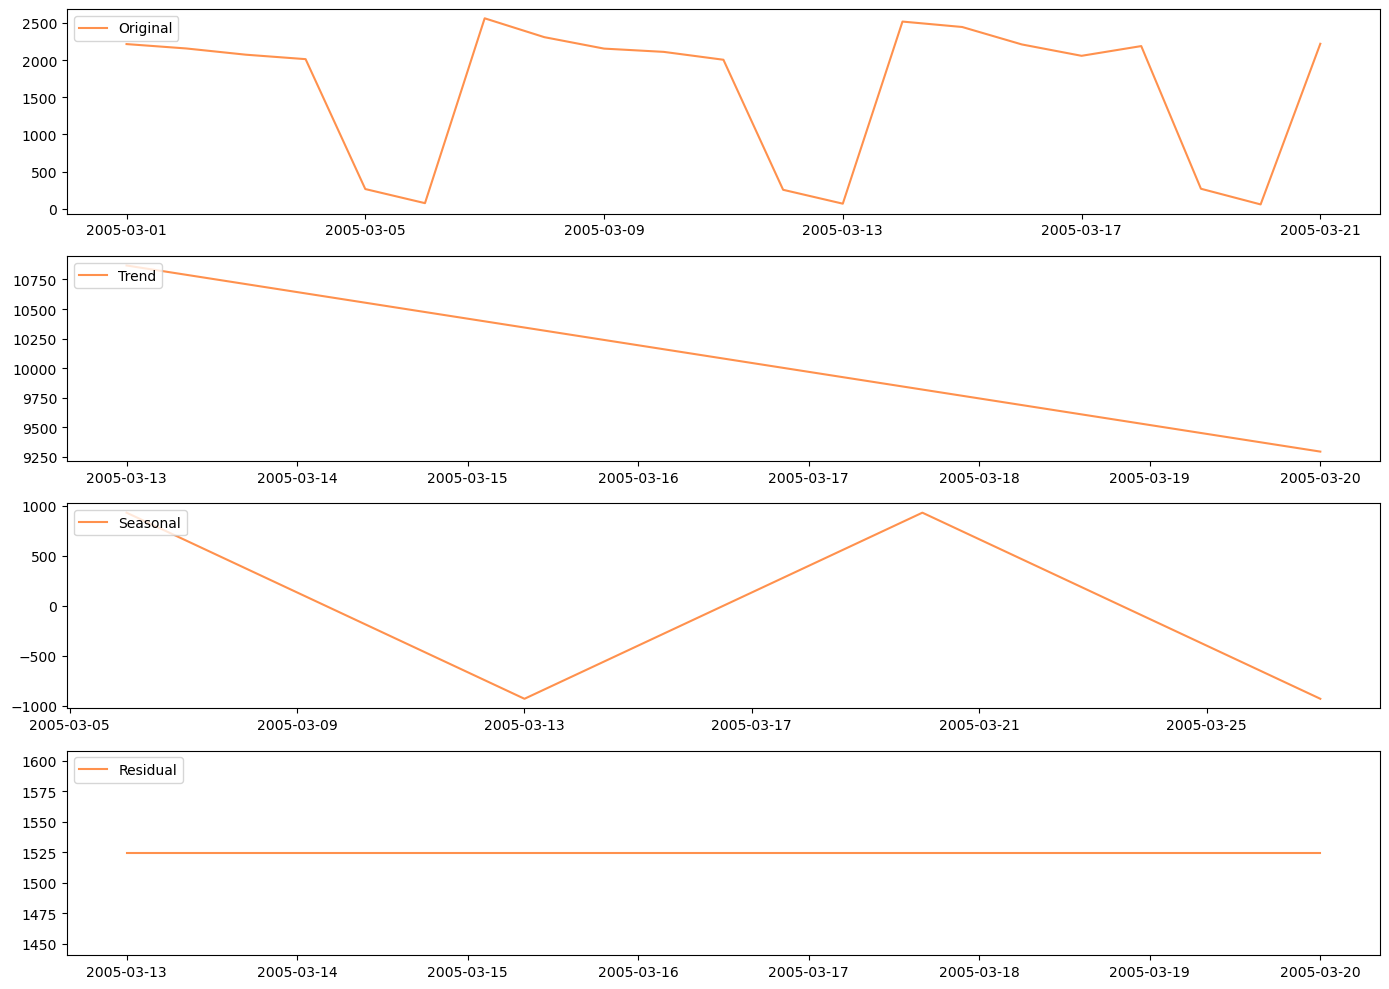

In [224]:
daily_demand = daily_demand.set_index('DATE')
decomposition_additive_daily = seasonal_decompose(daily_demand['DEMAND'], model='additive', period=7)
trend_additive = decomposition_additive.trend
seasonal_additive = decomposition_additive.seasonal
residual_additive = decomposition_additive.resid

# Plotting the additive decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(daily_demand['DEMAND'], label='Original', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_additive, label='Trend', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_additive, label='Seasonal', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_additive, label='Residual', color = '#FF914D')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


After decomposing the daily demand, it’s pretty obvious that there’s a clear weekly pattern — the seasonal part rises and drops consistently every 7 days, which totally matches what I saw earlier in the daily plots.
The trend seems to be going down slowly, so maybe demand is slightly dropping over time. The residual line is basically flat, which is actually a good sign, it means most of the changes are already explained by the trend and seasonality.
So overall, daily decomposition gives way more insight than weekly, especially when it comes to spotting short-term patterns.


**Q3:** Because ARIMA assumes the data has a constant mean and variance over time. If the data isn’t stationary, the model can give misleading results. So basically, if the trend or seasonality is still there, ARIMA won’t work well, it needs a stable pattern to build accurate forecasts.

**Q4:** It’s better to go with additive when the seasonality is more or less consistent and doesn’t depend on the level of the data. The seasonal ups and downs stay about the same no matter how high or low the demand is, so additive makes more sense. But if the seasonal effect got bigger as the trend increased, then multiplicative would probably be better.


**Part C**

**C1,C2,C3**

In [240]:
df['DATE'] = pd.to_datetime(df['DATE'])  
daily_demand = df.resample('D', on='DATE')['DEMAND'].sum().reset_index()
daily_demand['DATE'] = pd.to_datetime(daily_demand['DATE'])  
daily_demand.set_index('DATE', inplace= True)  

In [290]:

p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 7

# Fit the SARIMA model
model = SARIMAX(daily_demand['DEMAND'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88557D+00    |proj g|=  3.70209D-02

At iterate    5    f=  3.88277D+00    |proj g|=  6.15090D-03

At iterate   10    f=  3.87792D+00    |proj g|=  1.06388D-02

At iterate   15    f=  3.87669D+00    |proj g|=  6.11707D-03

At iterate   20    f=  3.86656D+00    |proj g|=  1.93656D-02

At iterate   25    f=  3.86300D+00    |proj g|=  5.90883D-04

At iterate   30    f=  3.83952D+00    |proj g|=  4.26905D-03

At iterate   35    f=  3.83932D+00    |proj g|=  2.88714D-03

At iterate   40    f=  3.83908D+00    |proj g|=  1.12401D-03

At iterate   45    f=  3.83906D+00    |proj g|=  5.65604D-04

At iterate   50    f=  3.83906D+00    |proj g|=  7.46572D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

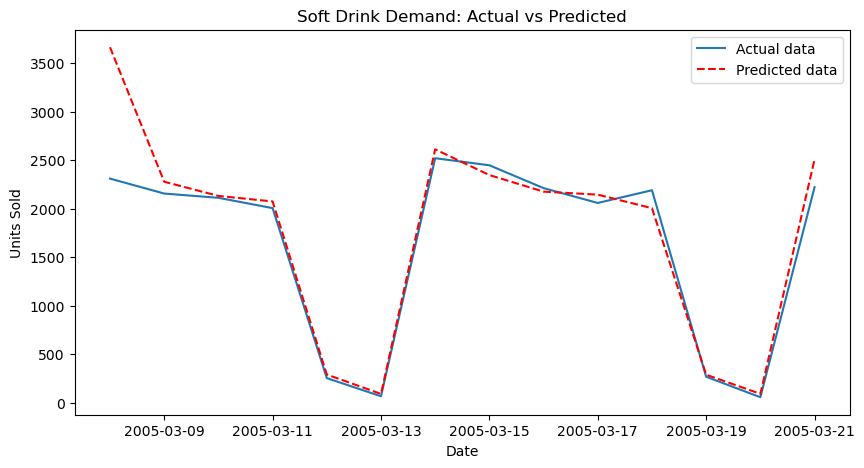

RMSE:  377.75


In [349]:
# Splitting the data into training
train = daily_demand['DEMAND'][:-14]  
test = daily_demand['DEMAND'][-14:]
predictions = model_fit.predict(
    start=len(train),
    end=len(train) + len(test)-1,
    dynamic=False)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual data')
plt.plot(test.index, predictions, color='red', linestyle='--', label='Predicted data')
plt.title('Soft Drink Demand: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test, predictions)),2)
print('RMSE: ',rmse)

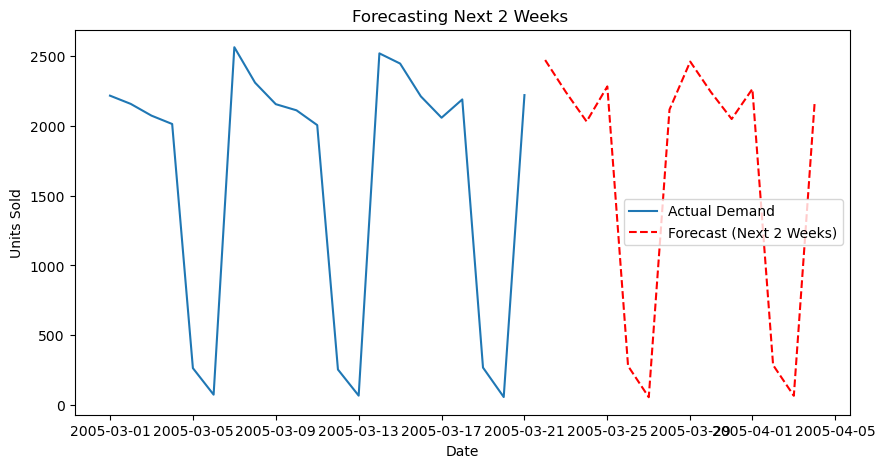

In [294]:

# Forecast the next 14 days
forecast = model_fit.forecast(steps=14)

# Create future dates for plotting
last_date = daily_demand.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14, freq='D')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(daily_demand.index, daily_demand['DEMAND'], label='Actual Demand')
plt.plot(future_dates, forecast, label='Forecast (Next 2 Weeks)', color='red', linestyle='--')
plt.title('Forecasting Next 2 Weeks ')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


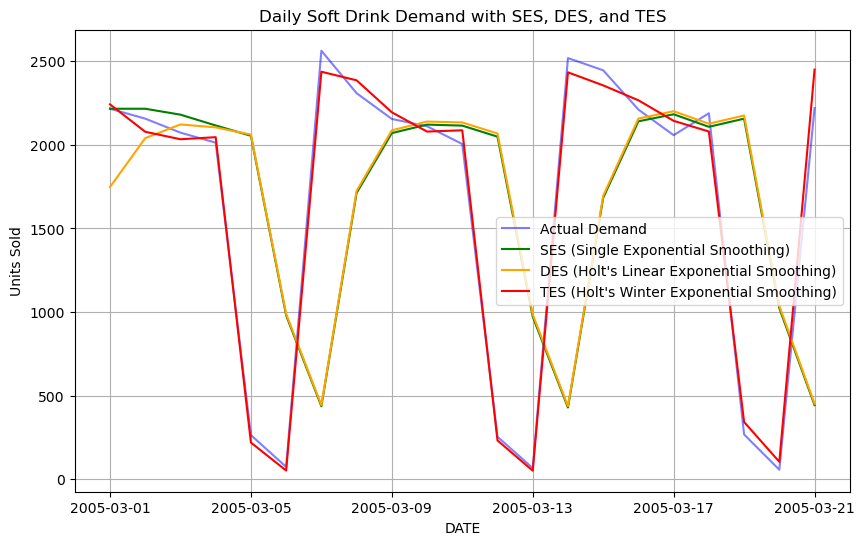

In [278]:
daily_demand['DEMAND']
daily_demand.index = pd.DatetimeIndex(daily_demand.index, freq='D')
ses_model = SimpleExpSmoothing(daily_demand['DEMAND']).fit(smoothing_level=0.6)
daily_demand['SES'] = ses_model.fittedvalues

# Double Exponential Smoothing (DES) - Holt's linear trend model
des_model = ExponentialSmoothing(daily_demand['DEMAND'], trend='add').fit(smoothing_level=0.6)
daily_demand['DES'] = des_model.fittedvalues

# Triple Exponential Smoothing (TES) - Holt-Winters method
tes_model = ExponentialSmoothing(daily_demand['DEMAND'], trend='add', seasonal='add', seasonal_periods=7).fit(smoothing_level=0.6)
daily_demand['TES'] = tes_model.fittedvalues

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(daily_demand.index,daily_demand['DEMAND'], label='Actual Demand', color='blue', alpha=0.5)
plt.plot(daily_demand.index,daily_demand['SES'], label='SES (Single Exponential Smoothing)', color='green')
plt.plot(daily_demand.index,daily_demand['DES'], label='DES (Holt\'s Linear Exponential Smoothing)', color='orange')
plt.plot(daily_demand.index,daily_demand['TES'], label='TES (Holt\'s Winter Exponential Smoothing)', color='red')

plt.title('Daily Soft Drink Demand with SES, DES, and TES')
plt.xlabel('DATE')
plt.ylabel('Units Sold')
plt.legend()
plt.grid()
plt.show()


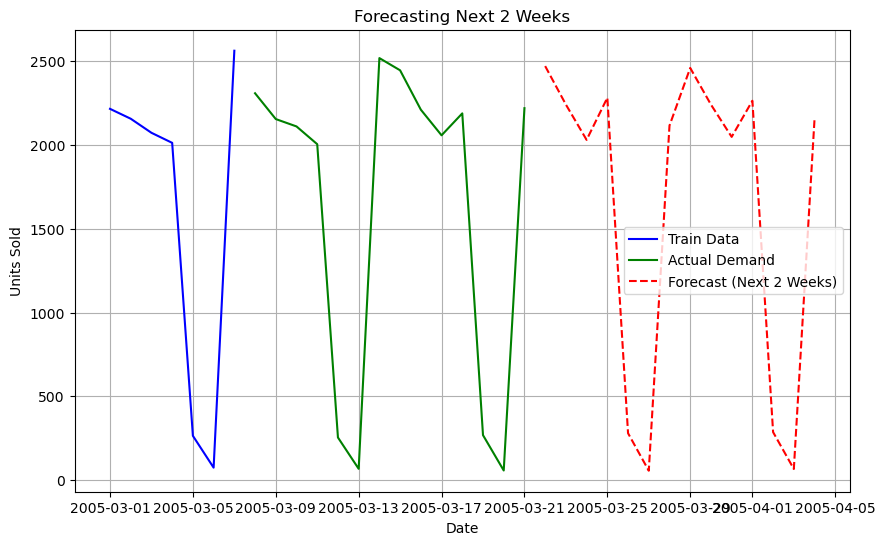

In [300]:
forecast_es = tes_model.forecast(14)
# plot
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Actual Demand', color='green')
plt.plot(forecast.index, forecast, label='Forecast (Next 2 Weeks)', color='red', linestyle='--')
plt.title('Forecasting Next 2 Weeks')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()

In [306]:
# Normalazing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_demand[['DEMAND']])
# create sequence
def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
X, y = create_sequences(scaled_data, seq_length=7)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split]
y_train, y_test = y[:split], y[split:]
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
# Train
model.fit(X_train, y_train, epochs=20, verbose=1)


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - loss: 0.7422
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7175
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6936
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6704
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6480
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6263
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6053
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5848
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5650
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5458
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5270
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5085
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4904
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4728
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4557
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


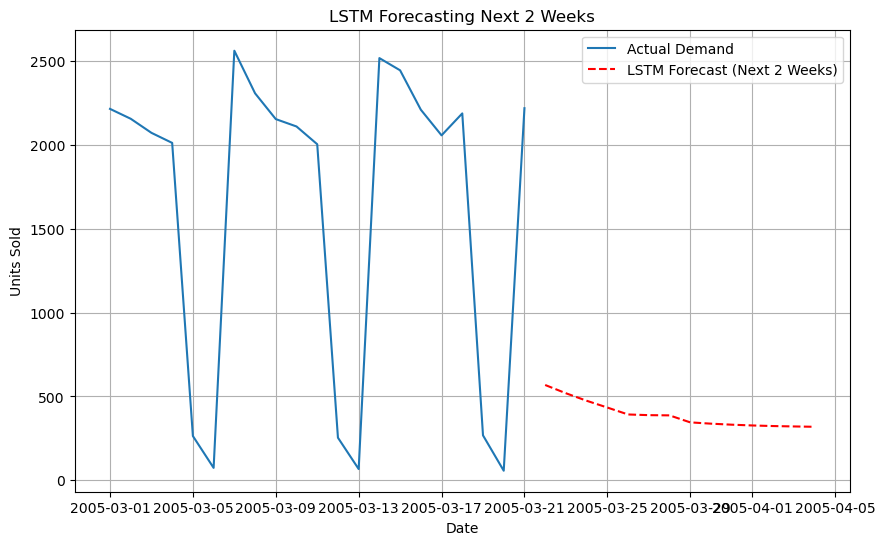

In [318]:
# Using the last 7 days from the dataset to predict the next 14 days
current_seq = scaled_data[-7:].reshape(1, 7, 1)
predictions_scaled = []
for _ in range(14):
    next_scaled_pred = model.predict(current_seq)[0, 0]
    predictions_scaled.append(next_scaled_pred)
    current_seq = np.append(current_seq[:, 1:, :], [[[next_scaled_pred]]], axis=1)
    
# Inverse
forecast = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).reshape(-1)
forecast_dates = pd.date_range(start=daily_demand.index[-1] + pd.Timedelta(days=1), periods=14)

plt.figure(figsize=(10, 6))
plt.plot(daily_demand.index, daily_demand['DEMAND'], label='Actual Demand')
plt.plot(forecast_dates, forecast, label='LSTM Forecast (Next 2 Weeks)', linestyle='--', color='red')
plt.title('LSTM Forecasting Next 2 Weeks')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()

**Q5**: First, I used the ADF test to check if the data was stationary. Since it wasn’t, I applied differencing to make it stable, which helped me decide the values for d and D.
Then I looked at the ACF and PACF plots. From the PACF plot, I estimated p, and from the ACF plot, I got q. For seasonal parts (P and Q), I did the same but used seasonal lags (like every 7 days, since it’s weekly).
I set s = 7 because the data shows a weekly pattern.
Finally, I tested a few combinations and chose the one that gave the lowest RMSE and worked best with the data.

**Part D**
**D1**

In [353]:
mae = mean_absolute_error(test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# 2. Mean Squared Error (MSE)
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# 3. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 4. Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((list(test) - predictions) / list(test))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

# aic and bic
aic = model_fit.aic
bic = model_fit.bic

print(f'Akaike Information Criterion (AIC): {aic}')
print(f'Bayesian Information Criterion (BIC): {bic}')


Mean Absolute Error (MAE): 176.0033338081533
Mean Squared Error (MSE): 142692.56413016465
Root Mean Squared Error (RMSE): 377.74669307641153
Mean Absolute Percentage Error (MAPE): 15.923378752883838%
Akaike Information Criterion (AIC): 171.24043050828942
Bayesian Information Criterion (BIC): 174.0651772955971


In [361]:
tes_predictions = tes_model.fittedvalues[-len(test):]


mae_tes = mean_absolute_error(test, tes_predictions)
print(f'Mean Absolute Error (MAE): {mae_tes}')

#Mean Squared Error (MSE)
mse_tes = mean_squared_error(test, tes_predictions)
print(f'Mean Squared Error (MSE): {mse_tes}')

#Root Mean Squared Error (RMSE)
rmse_tes = np.sqrt(mse_tes)
print(f'Root Mean Squared Error (RMSE): {rmse_tes}')

#Mean Absolute Percentage Error (MAPE)
mape_tes = np.mean(np.abs((list(test) - tes_predictions) / list(test))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape_tes}%')

Mean Absolute Error (MAE): 74.72770241849423
Mean Squared Error (MSE): 8176.852499267397
Root Mean Squared Error (RMSE): 90.42595036419246
Mean Absolute Percentage Error (MAPE): 13.100707591512215%


In [367]:
predictions_lstm = predictions_scaled[:len(y_test)]
# Mean Absolute Error (MAE)
mae_lstm = mean_absolute_error(y_test, predictions_lstm)
print(f'Mean Absolute Error (MAE): {mae_lstm}')

# Mean Squared Error (MSE)
mse_lstm = mean_squared_error(y_test, predictions_lstm)
print(f'Mean Squared Error (MSE): {mse_lstm}')

# Root Mean Squared Error (RMSE)
rmse_lstm = np.sqrt(mse_lstm)
print(f'Root Mean Squared Error (RMSE): {rmse_lstm}')

# Mean Absolute Percentage Error (MAPE)
mape_lstm = np.mean(np.abs((y_test - predictions_lstm) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape_lstm}%')

Mean Absolute Error (MAE): 0.33363873492723206
Mean Squared Error (MSE): 0.17784076841009913
Root Mean Squared Error (RMSE): 0.4217117124412116
Mean Absolute Percentage Error (MAPE): inf%


/var/folders/m_/pqldzfk929g_v5k72f6g6sx80000gn/T/ipykernel_31496/1504308836.py:15: RuntimeWarning: divide by zero encountered in divide
  mape_lstm = np.mean(np.abs((y_test - predictions_lstm) / y_test)) * 100


**D2,D3**

2.Between the three models(SARIMA, Exponential Smoothing (TES), and LSTM) TES performed the best overall. It had much lower MAE, MSE, and RMSE compared to the other two. LSTM looked promising at first with super low MAE and RMSE, but the MAPE couldn’t be calculated because of a divide by zero error, which probably means something went off with the test or prediction values. SARIMA also had higher error values, so it didn’t perform as well. So yes, based on everything, TES is definitely the most reliable model for forecasting demand here.

3.Based on the Triple Exponential Smoothing model, which showed the most accurate and consistent results, I’d suggest keeping the production the same or even slightly increasing it for next month. The model did a great job capturing the weekly demand trend, and it had the lowest error scores out of all three models. I feel pretty confident about this forecast since it matches the seasonality we’ve seen in the data. That said, it’s still a good idea to keep an eye on sales in case anything unexpected comes up.

They should slightly increase the production next month, based on the forecasted demand trend captured by the TES model. The prediction shows a consistent pattern, and error metrics were low, suggesting the demand is likely to stay steady or go up a bit.

I’m confident in the prediction since the TES model performed well and matched the weekly seasonality in the data. The error metrics were low, which makes the forecast reliable, but I’d still recommend keeping watching actual sales in case something unexpected happens.

**Q6:** Residuals are just the differences between what the model predicted and what actually happened. If they’re small and not showing any weird patterns, that’s a good sign the model is working well.
Confidence intervals are like a range around the forecast that shows how much uncertainty there is. It helps us understand how confident the model is in its prediction without assuming it’s 100% exact.

**Q7:** One of the main limitations is that the forecast only looks at past sales, so it kind of assumes that things will keep going the same way. It doesn’t consider unexpected stuff like promotions, weather changes, or supply problems. So if something unusual happens, the prediction might be off. That’s why it’s important to keep updating the model and checking how the actual sales go.